# Illustrative example of 1D noise example


In [1]:
# standard libraries
import time
import warnings


# third-party libraries
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from sklearn.metrics import r2_score
from mfpml.design_of_experiment.multifidelity_samplers import MFSobolSequence
from mfpml.models.gaussian_process import GaussianProcess
from mfpml.models.kernels import RBF
from mfpml.problems.multifidelity_functions import (
    Forrester_1c,
    Forrester_1a,
    Forrester_1b,
)


# local libraries
from mfbml.methods.mf_rbf_gpr import MFRBFGPR
from mfbml.get_methods.accuracy_metrics import (
    normalized_mae,
    normalized_rmse,
    log_likelihood_value,
)

# ignore warnings
warnings.filterwarnings("ignore")

## get function information


In [2]:
func1a = Forrester_1a()

noise_add = 0.3
num_hf_samples = 15
num_lf_samples = 200
optimizer_restart = 20
# define sampler
sampler = MFSobolSequence(design_space=func1a.design_space, seed=5)
sample_x = sampler.get_samples(
    num_hf_samples=num_hf_samples, num_lf_samples=num_lf_samples
)

sample_y_1a = {}
# get response
sample_y_1a["hf"] = func1a.hf(sample_x["hf"]) + np.random.normal(
    0, noise_add, size=sample_x["hf"].shape[0]
).reshape(-1, 1)
sample_y_1a["lf"] = func1a.lf(sample_x["lf"]) + np.random.normal(
    0, 0.3, size=sample_x["lf"].shape[0]
).reshape(-1, 1)

# generate test samples
test_x = np.linspace(0, 1, 1000).reshape(-1, 1)
test_hy = func1a.hf(test_x)
test_ly_1a = func1a.lf(test_x)

# generate noisy test data test_x_noisy
test_x_noisy = np.linspace(0, 1, 1000).reshape(-1, 1)
test_hy_noisy = func1a.hf(test_x_noisy) + np.random.normal(
    0, noise_add, size=test_x_noisy.shape[0]
).reshape(-1, 1)

## GPR model


In [3]:
# define kernel
start_time = time.time()
kernel = RBF(
    theta=np.ones(func1a.num_dim),
    bounds=[-2, 3],
)
gpr = GaussianProcess(
    design_space=func1a.input_domain,
    kernel=kernel,
    noise_prior=None,
    optimizer_restart=optimizer_restart,
)
gpr.train(sample_x=sample_x["hf"], sample_y=sample_y_1a["hf"])
end_time = time.time()
gpr_time = end_time - start_time
print("gpr time: ", end_time - start_time)
# get the trained parameters

theta_learned_gpr = np.log10(gpr.kernel.param)
noise_learned_gpr = gpr.noise

# print information to the screen
print("theta: ", theta_learned_gpr)
print("noise: ", noise_learned_gpr)

gpr time:  0.808779239654541
theta:  [1.85018268]
noise:  0.3713366377672085


gpr:  [70.82436402]
gpr:  [[0.48069757]]
gpr:  0.3713366377672085


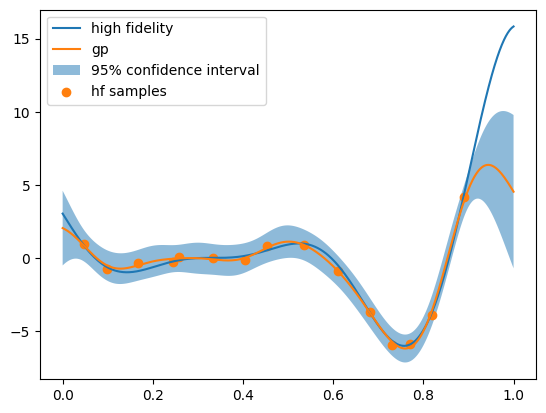

In [4]:
gpr_pred_y, gpr_pred_std = gpr.predict(x_predict=test_x, return_std=True)
print("gpr: ", gpr.kernel.param)
print("gpr: ", gpr.beta)
print("gpr: ", gpr.noise)
# plot
fig, ax = plt.subplots()
ax.plot(test_x, test_hy, label="high fidelity")
ax.plot(test_x, gpr_pred_y, label="gp")
ax.fill_between(
    test_x.flatten(),
    (gpr_pred_y - 1.96 * gpr_pred_std).flatten(),
    (gpr_pred_y + 1.96 * gpr_pred_std).flatten(),
    alpha=0.5,
    label="95% confidence interval",
)
ax.scatter(sample_x["hf"], sample_y_1a["hf"], label="hf samples")
ax.legend()
plt.show()

In [5]:
# plot the land scape of  log_likelihood function
#  generate the meshgrid for the parameters theta and noise
gpr.noise = None
theta = np.linspace(-2, 3, 100)
noise = np.linspace(0.01, 0.5, 100)
theta, noise = np.meshgrid(theta, noise)
# calculate the log_likelihood
log_likelihood_gpr = np.zeros(theta.shape)
for i in range(theta.shape[0]):
    for j in range(theta.shape[1]):
        list_params = [theta[i, j], noise[i, j]]
        log_likelihood_gpr[i, j] = gpr._logLikelihood(params=list_params)
# find the maximum log_likelihood
min_log_likelihood_gpr = np.min(log_likelihood_gpr)
print("min_negative_log_likelihood: ", min_log_likelihood_gpr)
# find the index of the maximum log_likelihood
idx = np.where(log_likelihood_gpr == min_log_likelihood_gpr)
print("best theta: ", theta[idx])
print("best noise: ", noise[idx])

min_negative_log_likelihood:  0.6955370245253789
best theta:  [1.83838384]
best noise:  [0.14363636]


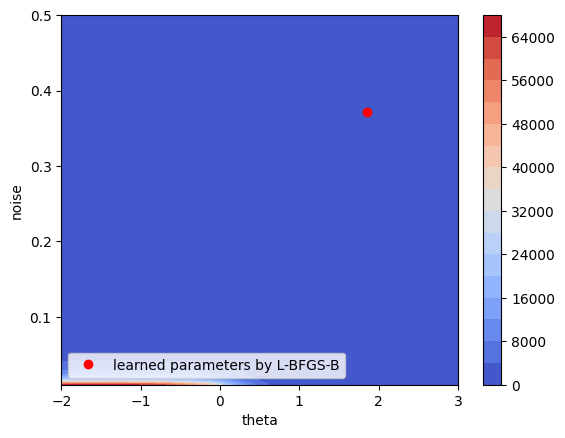

In [6]:
# plot the log_likelihood
fig, ax = plt.subplots()
cs = ax.contourf(theta, noise, log_likelihood_gpr, levels=20, cmap=cm.coolwarm)
ax.plot(
    theta_learned_gpr, noise_learned_gpr, "ro", label="learned parameters by L-BFGS-B"
)
# ax.plot(theta[idx], noise[idx], "b*", label="best parameters by grid search")
ax.legend(loc="lower left")
ax.set_xlabel("theta")
ax.set_ylabel("noise")
fig.colorbar(cs)
# plt.savefig("log_likelihood_gpr.png", dpi=300, bbox_inches="tight")
# plt.savefig("log_likelihood_gpr.svg", dpi=300, bbox_inches="tight")
plt.show()

## train mf-rbf-gpr model on Forrestor la funciton


In [7]:
# for developed methods
start_time = time.time()
mfrbfgp1a = MFRBFGPR(
    design_space=func1a.input_domain,
    noise_prior=None,
    optimizer_restart=optimizer_restart,
)
mfrbfgp1a.train(samples=sample_x, responses=sample_y_1a)
end_time = time.time()
mfrbfgp1a_time = end_time - start_time
print("mfrbfgp1a time: ", end_time - start_time)
theta_learned_mfrbfgp1a = np.log10(mfrbfgp1a.kernel.param)
noise_learned_mfrbfgp1a = mfrbfgp1a.noise

mfrbfgp1a time:  1.5621893405914307


mfrbfgp1a:  [0.01773871]
mfrbfgp1a:  [[1.83185395]
 [0.9806998 ]]
mfrbfgp1a:  0.25330915351993344


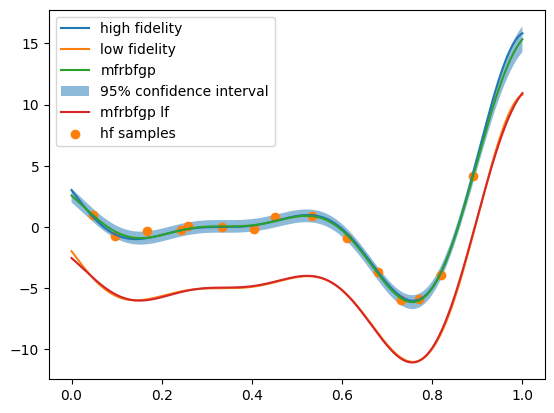

In [8]:
mfrbfgp_pred_y_1a, mfrbfgp_pred_std_1a = mfrbfgp1a.predict(
    x_predict=test_x, return_std=True
)
# get prediction of low fidelity
pred_ly1a = mfrbfgp1a.predict_lf(test_xl=test_x)

print("mfrbfgp1a: ", mfrbfgp1a.kernel.param)
print("mfrbfgp1a: ", mfrbfgp1a.beta)
print("mfrbfgp1a: ", mfrbfgp1a.noise)
# plot
fig, ax = plt.subplots()
ax.plot(test_x, test_hy, label="high fidelity")
ax.plot(test_x, test_ly_1a, label="low fidelity")
ax.plot(test_x, mfrbfgp_pred_y_1a, label="mfrbfgp")
ax.fill_between(
    test_x.flatten(),
    (mfrbfgp_pred_y_1a - 1.96 * mfrbfgp_pred_std_1a).flatten(),
    (mfrbfgp_pred_y_1a + 1.96 * mfrbfgp_pred_std_1a).flatten(),
    alpha=0.5,
    label="95% confidence interval",
)
ax.plot(test_x, pred_ly1a, label="mfrbfgp lf")
ax.scatter(sample_x["hf"], sample_y_1a["hf"], label="hf samples")
# ax.scatter(sample_x["lf"], sample_y_1a["lf"], label="lf samples")
ax.legend()
plt.show()

In [9]:
#  generate the meshgrid for the parameters theta and noise
mfrbfgp1a.noise = None
theta = np.linspace(-2, 3, 100)
noise = np.linspace(0.01, 0.5, 100)
theta, noise = np.meshgrid(theta, noise)
# calculate the log_likelihood
log_likelihood1a = np.zeros(theta.shape)
for i in range(theta.shape[0]):
    for j in range(theta.shape[1]):
        list_params = [theta[i, j], noise[i, j]]
        log_likelihood1a[i, j] = mfrbfgp1a._logLikelihood(params=list_params)

max_log_likelihood:  -23.669753542126426
theta:  [-1.74747475]
noise:  [0.09414141]


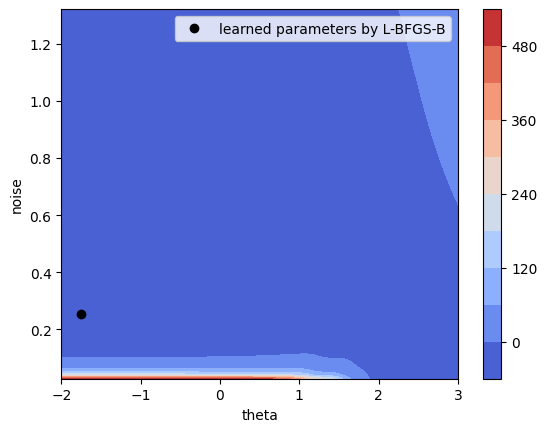

In [10]:
# find the maximum log_likelihood
min_log_likelihood = np.min(log_likelihood1a)
print("max_log_likelihood: ", min_log_likelihood)
# find the index of the maximum log_likelihood
idx = np.where(log_likelihood1a == min_log_likelihood)
print("theta: ", theta[idx])
print("noise: ", noise[idx])
# plot the log_likelihood
fig, ax = plt.subplots()
cs = ax.contourf(
    theta, noise * mfrbfgp1a.yh_std, log_likelihood1a, levels=10, cmap=cm.coolwarm
)
ax.plot(
    theta_learned_mfrbfgp1a,
    noise_learned_mfrbfgp1a,
    "ko",
    label="learned parameters by L-BFGS-B",
)
# ax.plot(theta[idx], noise[idx], "b*", label="best parameters by grid search")
ax.legend(loc="best")
ax.set_xlabel("theta")
ax.set_ylabel("noise")
fig.colorbar(cs)
# plt.savefig("mf_log_likelihood_1a.png", dpi=300, bbox_inches="tight")
plt.show()

## train mf-rbf-gpr model on Frrestor lb function


In [11]:
# define function
func1b = Forrester_1b()

sample_y_1b = {}
# get response
sample_y_1b["hf"] = sample_y_1a["hf"].copy()
sample_y_1b["lf"] = func1b.lf(sample_x["lf"]) + np.random.normal(
    0, 0.3, size=sample_x["lf"].shape[0]
).reshape(-1, 1)

# test data
test_ly_1b = func1b.lf(test_x)

In [12]:
start_time = time.time()
mfrbfgp1b = MFRBFGPR(
    design_space=func1b.input_domain,
    noise_prior=None,
    optimizer_restart=optimizer_restart,
)
mfrbfgp1b.train(samples=sample_x, responses=sample_y_1b)
end_time = time.time()
mfrbfgp1b_time = end_time - start_time
print("mfrbfgp1b time: ", end_time - start_time)
theta_learned_mfrbfgp1b = np.log10(mfrbfgp1b.kernel.param)
noise_learned_mfrbfgp1b = mfrbfgp1b.noise
print("learned theta: ", theta_learned_mfrbfgp1b)
print("learned noise: ", noise_learned_mfrbfgp1b)

mfrbfgp1b time:  1.902231216430664
learned theta:  [0.89155714]
learned noise:  0.2957344207822257


mfrbfgp1b:  [7.79035298]
mfrbfgp1b:  [[3.70286201]
 [1.81795053]]
mfrbfgp1b:  0.2957344207822257


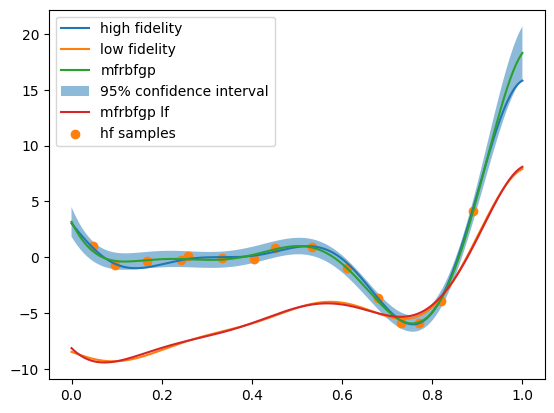

In [13]:
mfrbfgp_pred_y_1b, mfrbfgp_pred_std_1b = mfrbfgp1b.predict(
    x_predict=test_x, return_std=True
)
# get prediction of low fidelity
pred_ly1b = mfrbfgp1b.predict_lf(test_xl=test_x)

print("mfrbfgp1b: ", mfrbfgp1b.kernel.param)
print("mfrbfgp1b: ", mfrbfgp1b.beta)
print("mfrbfgp1b: ", mfrbfgp1b.noise)
# plot
fig, ax = plt.subplots()
ax.plot(test_x, test_hy, label="high fidelity")
ax.plot(test_x, test_ly_1b, label="low fidelity")
ax.plot(test_x, mfrbfgp_pred_y_1b, label="mfrbfgp")
ax.fill_between(
    test_x.flatten(),
    (mfrbfgp_pred_y_1b - 1.96 * mfrbfgp_pred_std_1b).flatten(),
    (mfrbfgp_pred_y_1b + 1.96 * mfrbfgp_pred_std_1b).flatten(),
    alpha=0.5,
    label="95% confidence interval",
)
ax.plot(test_x, pred_ly1b, label="mfrbfgp lf")
ax.scatter(sample_x["hf"], sample_y_1b["hf"], label="hf samples")
# ax.scatter(sample_x["lf"], sample_y_1a["lf"], label="lf samples")
ax.legend()
plt.show()

In [14]:
#  generate the meshgrid for the parameters theta and noise
mfrbfgp1b.noise = None
theta = np.linspace(-2, 3, 100)
noise = np.linspace(0.01, 0.5, 100)
theta, noise = np.meshgrid(theta, noise)
# calculate the log_likelihood
log_likelihood1b = np.zeros(theta.shape)
for i in range(theta.shape[0]):
    for j in range(theta.shape[1]):
        list_params = [theta[i, j], noise[i, j]]
        log_likelihood1b[i, j] = mfrbfgp1b._logLikelihood(params=list_params)

max_log_likelihood:  -6.927437315396279
theta:  [0.87878788]
noise:  [0.1089899]


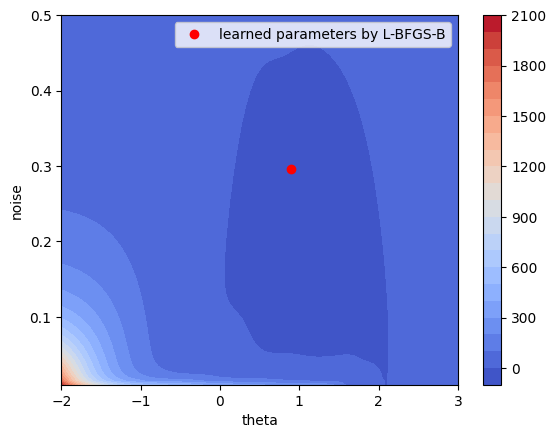

In [15]:
# find the maximum log_likelihood
min_log_likelihood = np.min(log_likelihood1b)
print("max_log_likelihood: ", min_log_likelihood)
# find the index of the maximum log_likelihood
idx = np.where(log_likelihood1b == min_log_likelihood)
print("theta: ", theta[idx])
print("noise: ", noise[idx])
# plot the log_likelihood
fig, ax = plt.subplots()
cs = ax.contourf(theta, noise, log_likelihood1b, levels=20, cmap=cm.coolwarm)
ax.plot(
    theta_learned_mfrbfgp1b,
    noise_learned_mfrbfgp1b,
    "ro",
    label="learned parameters by L-BFGS-B",
)
# ax.plot(theta[idx], noise[idx], "b*", label="best parameters by grid search")
ax.legend(loc="best")
ax.set_xlabel("theta")
ax.set_ylabel("noise")
fig.colorbar(cs)
# plt.savefig("mf_log_likelihood_1b.png", dpi=300, bbox_inches="tight")
plt.show()

## train mf-rbf-gpr on Forrester lc function


In [16]:
# define function
func1c = Forrester_1c()

sample_y_1c = {}
# get response
sample_y_1c["hf"] = sample_y_1a["hf"].copy()
sample_y_1c["lf"] = func1c.lf(sample_x["lf"]) + np.random.normal(
    0, 0.3, size=sample_x["lf"].shape[0]
).reshape(-1, 1)

# test data
test_ly_1c = func1c.lf(test_x)

In [17]:
start_time = time.time()
mfrbfgp1c = MFRBFGPR(
    design_space=func1c.input_domain,
    noise_prior=None,
    optimizer_restart=optimizer_restart,
)
mfrbfgp1c.train(samples=sample_x, responses=sample_y_1c)
end_time = time.time()
mfrbfgp1c_time = end_time - start_time
print("mfrbfgp1c time: ", end_time - start_time)
theta_learned_mfrbfgp1c = np.log10(mfrbfgp1c.kernel.param)
noise_learned_mfrbfgp1c = mfrbfgp1c.noise
print("learned theta: ", theta_learned_mfrbfgp1c)
print("learned noise: ", noise_learned_mfrbfgp1c)

mfrbfgp1c time:  3.2717530727386475
learned theta:  [1.33818572]
learned noise:  0.2851478845041241


mfrbfgp1c:  [21.78641224]
mfrbfgp1c:  [[ 1.41012897]
 [-0.55158785]]
mfrbfgp1c:  0.2851478845041241


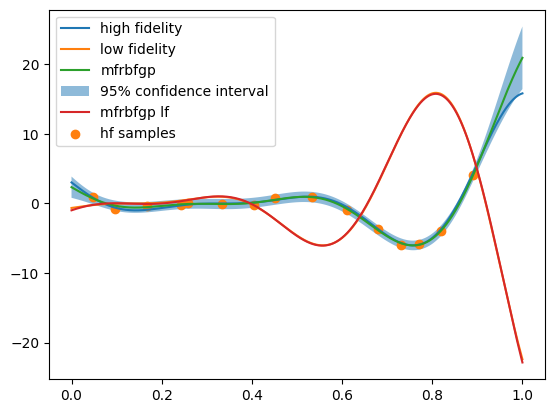

In [18]:
mfrbfgp_pred_y_1c, mfrbfgp_pred_std_1c = mfrbfgp1c.predict(
    x_predict=test_x, return_std=True
)
# get prediction of low fidelity
pred_ly1c = mfrbfgp1c.predict_lf(test_xl=test_x)

print("mfrbfgp1c: ", mfrbfgp1c.kernel.param)
print("mfrbfgp1c: ", mfrbfgp1c.beta)
print("mfrbfgp1c: ", mfrbfgp1c.noise)
# plot
fig, ax = plt.subplots()
ax.plot(test_x, test_hy, label="high fidelity")
ax.plot(test_x, test_ly_1c, label="low fidelity")
ax.plot(test_x, mfrbfgp_pred_y_1c, label="mfrbfgp")
ax.fill_between(
    test_x.flatten(),
    (mfrbfgp_pred_y_1c - 1.96 * mfrbfgp_pred_std_1c).flatten(),
    (mfrbfgp_pred_y_1c + 1.96 * mfrbfgp_pred_std_1c).flatten(),
    alpha=0.5,
    label="95% confidence interval",
)
ax.plot(test_x, pred_ly1c, label="mfrbfgp lf")
ax.scatter(sample_x["hf"], sample_y_1c["hf"], label="hf samples")
# ax.scatter(sample_x["lf"], sample_y_1a["lf"], label="lf samples")
ax.legend()
plt.show()

In [19]:
#  generate the meshgrid for the parameters theta and noise
mfrbfgp1c.noise = None
theta = np.linspace(-2, 3, 100)
noise = np.linspace(0.01, 0.5, 100)
theta, noise = np.meshgrid(theta, noise)
# calculate the log_likelihood
log_likelihood1c = np.zeros(theta.shape)
for i in range(theta.shape[0]):
    for j in range(theta.shape[1]):
        list_params = [theta[i, j], noise[i, j]]
        log_likelihood1c[i, j] = mfrbfgp1c._logLikelihood(params=list_params)

max_log_likelihood:  -6.350585056262453
theta:  [1.33333333]
noise:  [0.1089899]


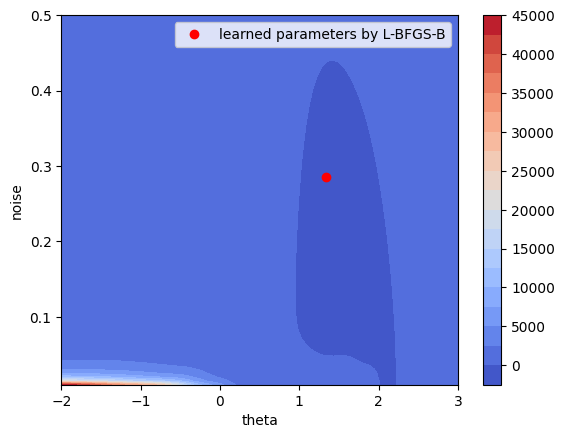

In [20]:
# find the maximum log_likelihood
min_log_likelihood = np.min(log_likelihood1c)
print("max_log_likelihood: ", min_log_likelihood)
# find the index of the maximum log_likelihood
idx = np.where(log_likelihood1c == min_log_likelihood)
print("theta: ", theta[idx])
print("noise: ", noise[idx])
# plot the log_likelihood
fig, ax = plt.subplots()
cs = ax.contourf(theta, noise, log_likelihood1c, levels=20, cmap=cm.coolwarm)
ax.plot(
    theta_learned_mfrbfgp1c,
    noise_learned_mfrbfgp1c,
    "ro",
    label="learned parameters by L-BFGS-B",
)
# ax.plot(theta[idx], noise[idx], "b*", label="best parameters by grid search")
ax.legend(loc="best")
ax.set_xlabel("theta")
ax.set_ylabel("noise")
fig.colorbar(cs)
# plt.savefig("mf_log_likelihood_1c.png", dpi=300, bbox_inches="tight")
plt.show()

## plot predictions on log marginal likelihood values


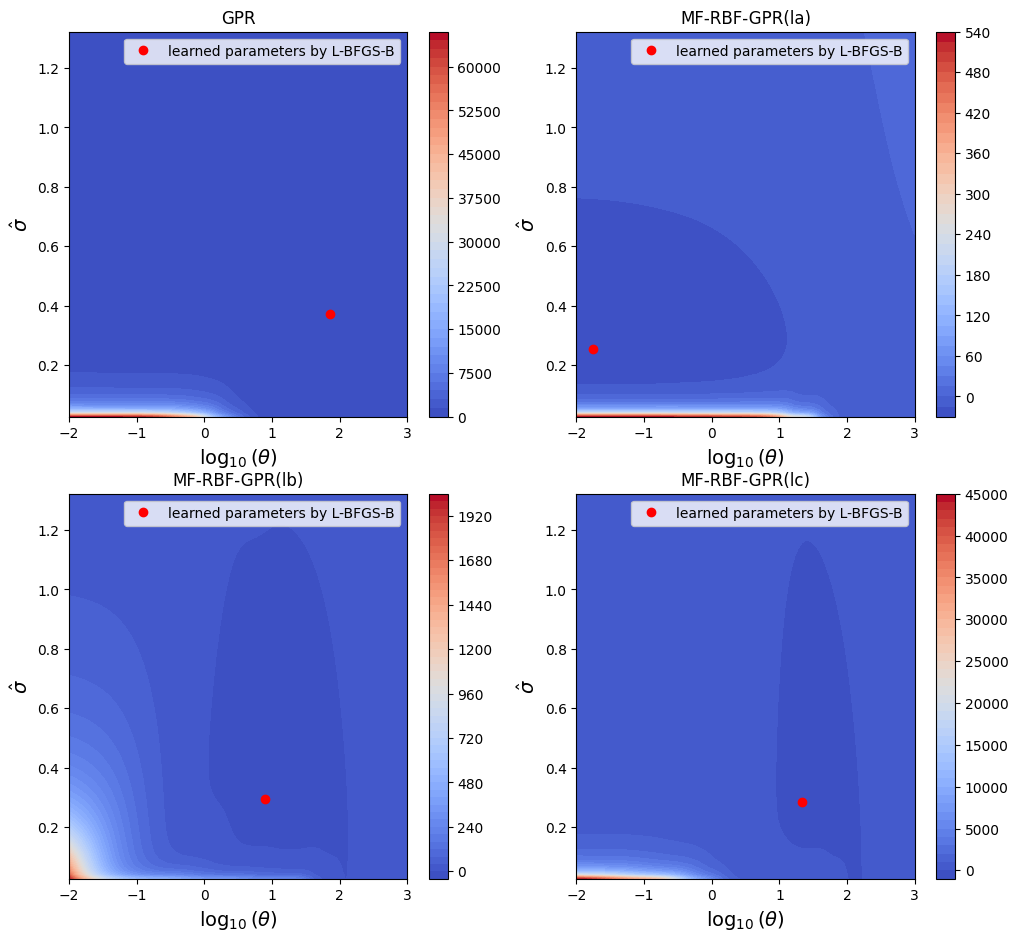

In [21]:
# plot the land scape of  log_likelihood function for all three functions and gpr method

fig, ax = plt.subplots(2, 2, figsize=(12, 11))
# plot the log_likelihood
cs = ax[0, 0].contourf(
    theta, noise * gpr.y_std, log_likelihood_gpr, levels=50, cmap=cm.coolwarm
)
ax[0, 0].plot(
    theta_learned_gpr, noise_learned_gpr, "ro", label="learned parameters by L-BFGS-B"
)
ax[0, 0].legend(loc="best")
ax[0, 0].set_xlabel(r"$\log_{10}(\theta)$", fontsize=14)
ax[0, 0].set_ylabel(r"$\hat{\sigma}$", fontsize=14)
ax[0, 0].set_title("GPR")
fig.colorbar(cs)
# plot the log_likelihood
cs = ax[0, 1].contourf(
    theta, noise * mfrbfgp1a.yh_std, log_likelihood1a, levels=50, cmap=cm.coolwarm
)
ax[0, 1].plot(
    theta_learned_mfrbfgp1a,
    noise_learned_mfrbfgp1a,
    "ro",
    label="learned parameters by L-BFGS-B",
)
ax[0, 1].legend(loc="best")
ax[0, 1].set_xlabel(r"$\log_{10}(\theta)$", fontsize=14)
ax[0, 1].set_ylabel(r"$\hat{\sigma}$", fontsize=14)
ax[0, 1].set_title("MF-RBF-GPR(la)")
fig.colorbar(cs)
# plot the log_likelihood
cs = ax[1, 0].contourf(
    theta, noise * mfrbfgp1b.yh_std, log_likelihood1b, levels=50, cmap=cm.coolwarm
)
ax[1, 0].plot(
    theta_learned_mfrbfgp1b,
    noise_learned_mfrbfgp1b,
    "ro",
    label="learned parameters by L-BFGS-B",
)
ax[1, 0].legend(loc="best")
ax[1, 0].set_xlabel(r"$\log_{10}(\theta)$", fontsize=14)
ax[1, 0].set_ylabel(r"$\hat{\sigma}$", fontsize=14)
ax[1, 0].set_title("MF-RBF-GPR(lb)")
fig.colorbar(cs)
# plot the log_likelihood
cs = ax[1, 1].contourf(
    theta, noise * mfrbfgp1c.yh_std, log_likelihood1c, levels=50, cmap=cm.coolwarm
)
ax[1, 1].plot(
    theta_learned_mfrbfgp1c,
    noise_learned_mfrbfgp1c,
    "ro",
    label="learned parameters by L-BFGS-B",
)
ax[1, 1].legend(loc="best")
ax[1, 1].set_xlabel(r"$\log_{10}(\theta)$", fontsize=14)
ax[1, 1].set_ylabel(r"$\hat{\sigma}$", fontsize=14)
ax[1, 1].set_title("MF-RBF-GPR(lc)")
fig.colorbar(cs)
plt.savefig("neg_log_likelihood_comparison.png", dpi=300, bbox_inches="tight")
plt.savefig("neg_log_likelihood_comparison.svg", dpi=300, bbox_inches="tight")
plt.savefig("neg_log_likelihood_comparison.pdf", dpi=300, bbox_inches="tight")
plt.show()

In [24]:
fig, ax = plt.subplots(2, 2, figsize=(12, 11))
# plot the log_likelihood
cs = ax[0, 0].contourf(
    theta,
    noise * gpr.y_std,
    log_likelihood_gpr,
    levels=np.linspace(log_likelihood_gpr.min(), 100, 50),
    cmap=cm.coolwarm,
)
ax[0, 0].plot(
    theta_learned_gpr, noise_learned_gpr, "ro", label="learned parameters by L-BFGS-B"
)
ax[0, 0].legend(loc="best")
ax[0, 0].set_xlabel(r"$\log_{10}(\theta)$", fontsize=14)
ax[0, 0].set_ylabel(r"$\hat{\sigma}$", fontsize=14)
ax[0, 0].set_title("GPR")
fig.colorbar(cs)
# plot the log_likelihood
cs = ax[0, 1].contourf(
    theta,
    noise * mfrbfgp1a.yh_std,
    log_likelihood1a,
    levels=np.linspace(log_likelihood1a.min(), 100, 50),
    cmap=cm.coolwarm,
)
ax[0, 1].plot(
    theta_learned_mfrbfgp1a,
    noise_learned_mfrbfgp1a,
    "ro",
    label="learned parameters by L-BFGS-B",
)
ax[0, 1].legend(loc="best")
ax[0, 1].set_xlabel(r"$\log_{10}(\theta)$", fontsize=14)
ax[0, 1].set_ylabel(r"$\hat{\sigma}$", fontsize=14)
ax[0, 1].set_title("MF-RBF-GPR(la)")
fig.colorbar(cs)
# plot the log_likelihood
cs = ax[1, 0].contourf(
    theta,
    noise * mfrbfgp1b.yh_std,
    log_likelihood1b,
    levels=np.linspace(log_likelihood1b.min(), 100, 50),
    cmap=cm.coolwarm,
)
ax[1, 0].plot(
    theta_learned_mfrbfgp1b,
    noise_learned_mfrbfgp1b,
    "ro",
    label="learned parameters by L-BFGS-B",
)
ax[1, 0].legend(loc="best")
ax[1, 0].set_xlabel(r"$\log_{10}(\theta)$", fontsize=14)
ax[1, 0].set_ylabel(r"$\hat{\sigma}$", fontsize=14)
ax[1, 0].set_title("MF-RBF-GPR(lb)")
fig.colorbar(cs)
# plot the log_likelihood
cs = ax[1, 1].contourf(
    theta,
    noise * mfrbfgp1c.yh_std,
    log_likelihood1c,
    levels=np.linspace(log_likelihood1c.min(), 100, 50),
    cmap=cm.coolwarm,
)
ax[1, 1].plot(
    theta_learned_mfrbfgp1c,
    noise_learned_mfrbfgp1c,
    "ro",
    label="learned parameters by L-BFGS-B",
)
ax[1, 1].legend(loc="best")
ax[1, 1].set_xlabel(r"$\log_{10}(\theta)$", fontsize=14)
ax[1, 1].set_ylabel(r"$\hat{\sigma}$", fontsize=14)
ax[1, 1].set_title("MF-RBF-GPR(lc)")
fig.colorbar(cs)
plt.savefig("neg_log_likelihood_comparison_zoom_in.png",
            dpi=300, bbox_inches="tight")
plt.savefig("neg_log_likelihood_comparison_zoom_in.svg",
            dpi=300, bbox_inches="tight")
plt.savefig("neg_log_likelihood_comparison_zoom_in.pdf",
            dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
# output the learned parameters
print("gpr theta: ", gpr.kernel.param)
print("gpr beta: ", gpr.beta)
print("gpr noise: ", noise_learned_gpr)
print("mfrbfgp1a theta: ", mfrbfgp1a.kernel.param)
print("mfrbfgp1a beta: ", mfrbfgp1a.beta)
print("mfrbfgp1a noise: ", noise_learned_mfrbfgp1a)
print("mfrbfgp1b theta: ", mfrbfgp1b.kernel.param)
print("mfrbfgp1b beta: ", mfrbfgp1b.beta)
print("mfrbfgp1b noise: ", noise_learned_mfrbfgp1b)
print("mfrbfgp1c theta: ", mfrbfgp1c.kernel.param)
print("mfrbfgp1c beta: ", mfrbfgp1c.beta)
print("mfrbfgp1c noise: ", noise_learned_mfrbfgp1c)

gpr theta:  [68.867713]
gpr beta:  [[0.53485569]]
gpr noise:  0.270319079688552
mfrbfgp1a theta:  [0.01]
mfrbfgp1a beta:  [[1.95914082]
 [0.99871033]]
mfrbfgp1a noise:  0.3183921735487271
mfrbfgp1b theta:  [17.44813998]
mfrbfgp1b beta:  [[3.51948195]
 [1.6107226 ]]
mfrbfgp1b noise:  0.24281911165726838
mfrbfgp1c theta:  [18.7818908]
mfrbfgp1c beta:  [[ 1.26735603]
 [-0.57876153]]
mfrbfgp1c noise:  0.24676844645836907


#


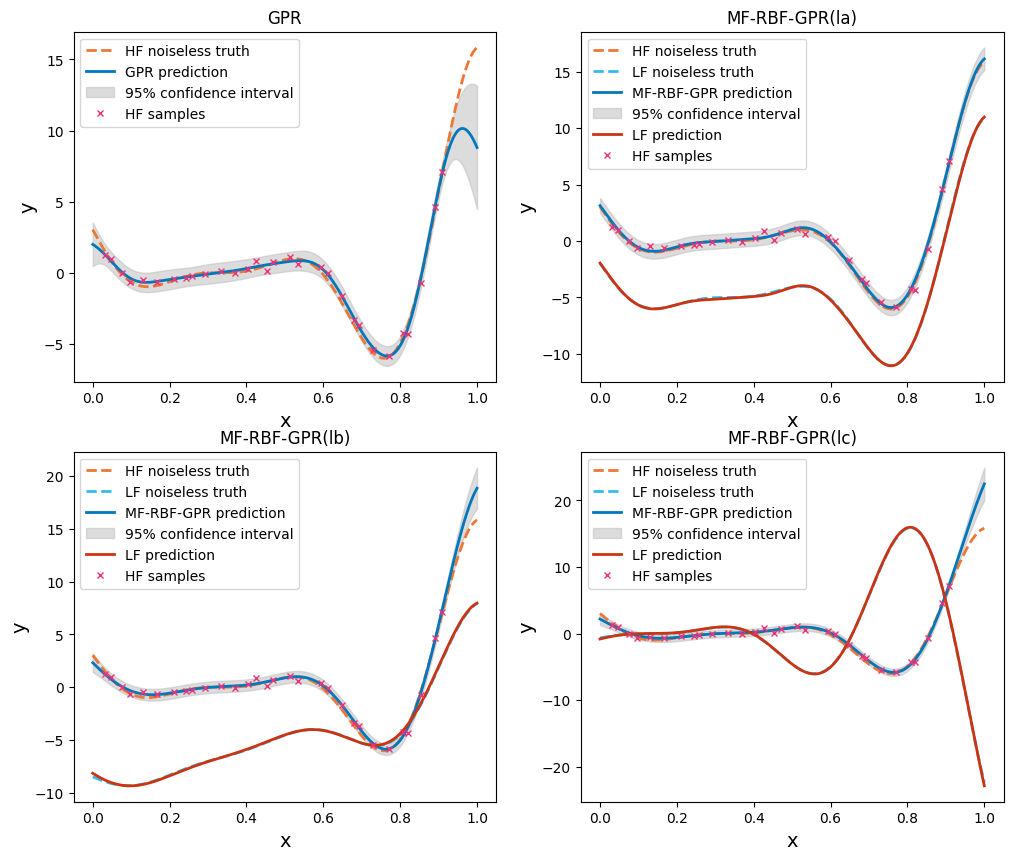

In [ ]:
# plot the prediction
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(
    test_x, test_hy, "--", color="#EE7733", linewidth=2, label="HF noiseless truth"
)
ax[0, 0].plot(
    test_x, gpr_pred_y, "-", color="#0077BB", linewidth=2, label="GPR prediction"
)
ax[0, 0].fill_between(
    test_x.flatten(),
    (gpr_pred_y - 1.96 * gpr_pred_std).flatten(),
    (gpr_pred_y + 1.96 * gpr_pred_std).flatten(),
    alpha=0.5,
    color="#BBBBBB",
    label="95% confidence interval",
)
ax[0, 0].plot(
    sample_x["hf"],
    sample_y_1a["hf"],
    "x",
    color="#EE3377",
    linewidth=2,
    markersize=5,
    label="HF samples",
)
ax[0, 0].set_xlabel("x", fontsize=14)
ax[0, 0].set_ylabel("y", fontsize=14)
ax[0, 0].legend()
ax[0, 0].set_title("GPR")
ax[0, 1].plot(
    test_x, test_hy, "--", color="#EE7733", linewidth=2, label="HF noiseless truth"
)
ax[0, 1].plot(
    test_x, test_ly_1a, "--", color="#33BBEE", linewidth=2, label="LF noiseless truth"
)
ax[0, 1].plot(
    test_x,
    mfrbfgp_pred_y_1a,
    "-",
    color="#0077BB",
    linewidth=2,
    label="MF-RBF-GPR prediction",
)
ax[0, 1].fill_between(
    test_x.flatten(),
    (mfrbfgp_pred_y_1a - 1.96 * mfrbfgp_pred_std_1a).flatten(),
    (mfrbfgp_pred_y_1a + 1.96 * mfrbfgp_pred_std_1a).flatten(),
    alpha=0.5,
    color="#BBBBBB",
    label="95% confidence interval",
)
ax[0, 1].plot(
    test_x, pred_ly1a, "-", color="#CC3311", linewidth=2, label="LF prediction"
)
ax[0, 1].plot(
    sample_x["hf"],
    sample_y_1a["hf"],
    "x",
    color="#EE3377",
    linewidth=2,
    markersize=5,
    label="HF samples",
)
ax[0, 1].set_xlabel("x", fontsize=14)
ax[0, 1].set_ylabel("y", fontsize=14)
ax[0, 1].legend()
ax[0, 1].set_title("MF-RBF-GPR(la)")
ax[1, 0].plot(
    test_x, test_hy, "--", color="#EE7733", linewidth=2, label="HF noiseless truth"
)
ax[1, 0].plot(
    test_x, test_ly_1b, "--", color="#33BBEE", linewidth=2, label="LF noiseless truth"
)
ax[1, 0].plot(
    test_x,
    mfrbfgp_pred_y_1b,
    "-",
    color="#0077BB",
    linewidth=2,
    label="MF-RBF-GPR prediction",
)
ax[1, 0].fill_between(
    test_x.flatten(),
    (mfrbfgp_pred_y_1b - 1.96 * mfrbfgp_pred_std_1b).flatten(),
    (mfrbfgp_pred_y_1b + 1.96 * mfrbfgp_pred_std_1b).flatten(),
    alpha=0.5,
    color="#BBBBBB",
    label="95% confidence interval",
)
ax[1, 0].plot(
    test_x, pred_ly1b, "-", color="#CC3311", linewidth=2, label="LF prediction"
)
ax[1, 0].plot(
    sample_x["hf"],
    sample_y_1b["hf"],
    "x",
    color="#EE3377",
    linewidth=2,
    markersize=5,
    label="HF samples",
)
ax[1, 0].set_xlabel("x", fontsize=14)
ax[1, 0].set_ylabel("y", fontsize=14)
ax[1, 0].legend()
ax[1, 0].set_title("MF-RBF-GPR(lb)")
ax[1, 1].plot(
    test_x, test_hy, "--", color="#EE7733", linewidth=2, label="HF noiseless truth"
)
ax[1, 1].plot(
    test_x, test_ly_1c, "--", color="#33BBEE", linewidth=2, label="LF noiseless truth"
)
ax[1, 1].plot(
    test_x,
    mfrbfgp_pred_y_1c,
    "-",
    color="#0077BB",
    linewidth=2,
    label="MF-RBF-GPR prediction",
)
ax[1, 1].fill_between(
    test_x.flatten(),
    (mfrbfgp_pred_y_1c - 1.96 * mfrbfgp_pred_std_1c).flatten(),
    (mfrbfgp_pred_y_1c + 1.96 * mfrbfgp_pred_std_1c).flatten(),
    alpha=0.5,
    color="#BBBBBB",
    label="95% confidence interval",
)
ax[1, 1].plot(
    test_x, pred_ly1c, "-", color="#CC3311", linewidth=2, label="LF prediction"
)
ax[1, 1].plot(
    sample_x["hf"],
    sample_y_1c["hf"],
    "x",
    color="#EE3377",
    linewidth=2,
    markersize=5,
    label="HF samples",
)
ax[1, 1].set_xlabel("x", fontsize=14)
ax[1, 1].set_ylabel("y", fontsize=14)
ax[1, 1].legend()
ax[1, 1].set_title("MF-RBF-GPR(lc)")
plt.savefig("prediction_comparison.png", dpi=300, bbox_inches="tight")
plt.savefig("prediction_comparison.svg", dpi=300, bbox_inches="tight")
plt.savefig("prediction_comparison.pdf", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
# calculate the rmse, mae, r2 score and nll for all three functions
# gpr
import pandas as pd

gpr_rmse = normalized_rmse(test_hy, gpr_pred_y)
gpr_mae = normalized_mae(test_hy, gpr_pred_y)
gpr_r2 = r2_score(test_hy, gpr_pred_y)
gpr_nll = log_likelihood_value(test_hy_noisy, gpr_pred_y, gpr_pred_std)
# print("gpr_rmse: ", gpr_rmse)
# print("gpr_mae: ", gpr_mae)
# print("gpr_r2: ", gpr_r2)
# print("gpr_nll: ", gpr_nll)

# mfrbfgp1a
mfrbfgp1a_rmse = normalized_rmse(test_hy, mfrbfgp_pred_y_1a)
mfrbfgp1a_mae = normalized_mae(test_hy, mfrbfgp_pred_y_1a)
mfrbfgp1a_r2 = r2_score(test_hy, mfrbfgp_pred_y_1a)
mfrbfgp1a_nll = log_likelihood_value(
    test_hy_noisy, mfrbfgp_pred_y_1a, mfrbfgp_pred_std_1a
)
# print("mfrbfgp1a_rmse: ", mfrbfgp1a_rmse)
# print("mfrbfgp1a_mae: ", mfrbfgp1a_mae)
# print("mfrbfgp1a_r2: ", mfrbfgp1a_r2)
# print("mfrbfgp1a_nll: ", mfrbfgp1a_nll)

# mfrbfgp1b
mfrbfgp1b_rmse = normalized_rmse(test_hy, mfrbfgp_pred_y_1b)
mfrbfgp1b_mae = normalized_mae(test_hy, mfrbfgp_pred_y_1b)
mfrbfgp1b_r2 = r2_score(test_hy, mfrbfgp_pred_y_1b)
mfrbfgp1b_nll = log_likelihood_value(
    test_hy_noisy, mfrbfgp_pred_y_1b, mfrbfgp_pred_std_1b
)
# print("mfrbfgp1b_rmse: ", mfrbfgp1b_rmse)
# print("mfrbfgp1b_mae: ", mfrbfgp1b_mae)
# print("mfrbfgp1b_r2: ", mfrbfgp1b_r2)
# print("mfrbfgp1b_nll: ", mfrbfgp1b_nll)

# mfrbfgp1c
mfrbfgp1c_rmse = normalized_rmse(test_hy, mfrbfgp_pred_y_1c)
mfrbfgp1c_mae = normalized_mae(test_hy, mfrbfgp_pred_y_1c)
mfrbfgp1c_r2 = r2_score(test_hy, mfrbfgp_pred_y_1c)
mfrbfgp1c_nll = log_likelihood_value(
    test_hy_noisy, mfrbfgp_pred_y_1c, mfrbfgp_pred_std_1c
)

# print("mfrbfgp1c_rmse: ", mfrbfgp1c_rmse)
# print("mfrbfgp1c_mae: ", mfrbfgp1c_mae)
# print("mfrbfgp1c_r2: ", mfrbfgp1c_r2)
# print("mfrbfgp1c_nll: ", mfrbfgp1c_nll)

# save all those results to pandas dataframe
# create a dictionary
data = {
    "nrmse": [gpr_rmse, mfrbfgp1a_rmse, mfrbfgp1b_rmse, mfrbfgp1c_rmse],
    "nmae": [gpr_mae, mfrbfgp1a_mae, mfrbfgp1b_mae, mfrbfgp1c_mae],
    "r2": [gpr_r2, mfrbfgp1a_r2, mfrbfgp1b_r2, mfrbfgp1c_r2],
    "nll": [gpr_nll, mfrbfgp1a_nll, mfrbfgp1b_nll, mfrbfgp1c_nll],
    "cpu_time": [gpr_time, mfrbfgp1a_time, mfrbfgp1b_time, mfrbfgp1c_time],
    "noise": [
        noise_learned_gpr,
        noise_learned_mfrbfgp1a,
        noise_learned_mfrbfgp1b,
        noise_learned_mfrbfgp1c,
    ],
    "beta": [gpr.beta, mfrbfgp1a.beta, mfrbfgp1b.beta, mfrbfgp1c.beta],
}
# create a dataframe
df = pd.DataFrame(data, index=["gpr", "mfrbfgp1a", "mfrbfgp1b", "mfrbfgp1c"])
print(df)

# save the dataframe to csv file
df.to_csv("comparison.csv")

              nrmse      nmae        r2          nll  cpu_time     noise  \
gpr        0.444961  2.708106  0.933246  -792.834997  1.261967  0.270319   
mfrbfgp1a  0.047042  0.114889  0.999254  -311.798472  3.748896  0.318392   
mfrbfgp1b  0.209746  1.160601  0.985167  -761.663117  5.029698  0.242819   
mfrbfgp1c  0.406410  2.570353  0.944312 -1236.561976  8.231696  0.246768   

                                                   beta  
gpr                              [[0.5348556860619659]]  
mfrbfgp1a  [[1.9591408179664875], [0.9987103336397211]]  
mfrbfgp1b   [[3.519481947370476], [1.6107226042998783]]  
mfrbfgp1c  [[1.267356033562085], [-0.5787615255877757]]  
